In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

root = Path("..")  # assuming notebook lives in notebooks/
log_path = root / "logs" / "predictions.jsonl"

log_path, log_path.exists()

(WindowsPath('../logs/predictions.jsonl'), True)

In [4]:
df = pd.read_json(log_path, lines=True)
df.head()

,logged_at_utc,endpoint,timestamp_utc,city,predicted_aqi_3h,predicted_label_3h,pm2_5,pm10,temp_c,humidity,explanation
0,2025-11-17T23:47:23.379686,/forecast/3h/explain,2025-11-17 20:45:32.788634+00:00,los_angeles,2.000238,Fair,0.90,2.18,16.72,82,"In Los Angeles, expect fair air quality with a..."
1,2025-11-17T23:47:23.379686,/forecast/3h/explain,2025-11-17 20:45:32.788634+00:00,atlanta,1.013640,Good,2.62,3.44,18.83,23,"In three hours, Atlanta's air quality is expec..."
2,2025-11-17T23:47:23.379686,/forecast/3h/explain,2025-11-17 20:45:32.788634+00:00,new_york,2.002549,Fair,0.50,0.85,6.69,40,"In New York City, within three hours you can e..."
3,2025-11-17T23:47:27.248208,/forecast/3h/explain,2025-11-17 20:45:32.788634+00:00,los_angeles,2.000238,Fair,0.90,2.18,16.72,82,"In Los Angeles, air quality is expected to rem..."
4,2025-11-17T23:47:27.248208,/forecast/3h/explain,2025-11-17 20:45:32.788634+00:00,atlanta,1.013640,Good,2.62,3.44,18.83,23,The forecast indicates Atlanta's air quality w...


c:\Users\Anes\anaconda3\envs\python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


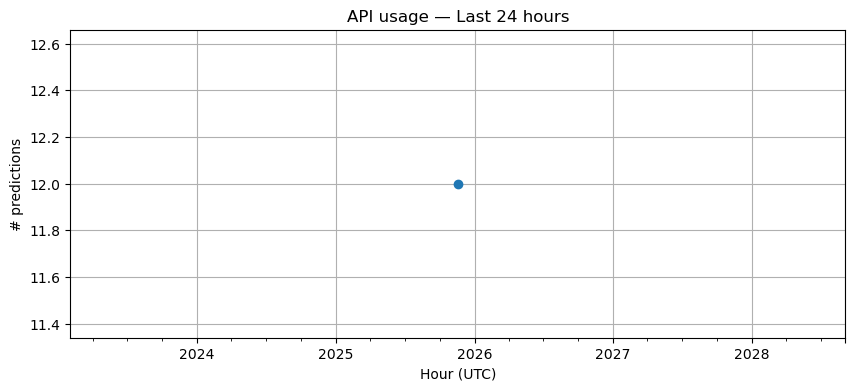

In [5]:
df["logged_at_utc"] = pd.to_datetime(df["logged_at_utc"])
df = df.sort_values("logged_at_utc")

# Filter to last 24 hours only
last_24h = df[df["logged_at_utc"] >= df["logged_at_utc"].max() - pd.Timedelta(hours=24)]

calls_per_hour = (
    last_24h
    .set_index("logged_at_utc")
    .resample("1h")["city"]
    .count()
)

plt.figure(figsize=(10, 4))
calls_per_hour.plot(marker='o')
plt.title("API usage — Last 24 hours")
plt.ylabel("# predictions")
plt.xlabel("Hour (UTC)")
plt.grid(True)
plt.show()

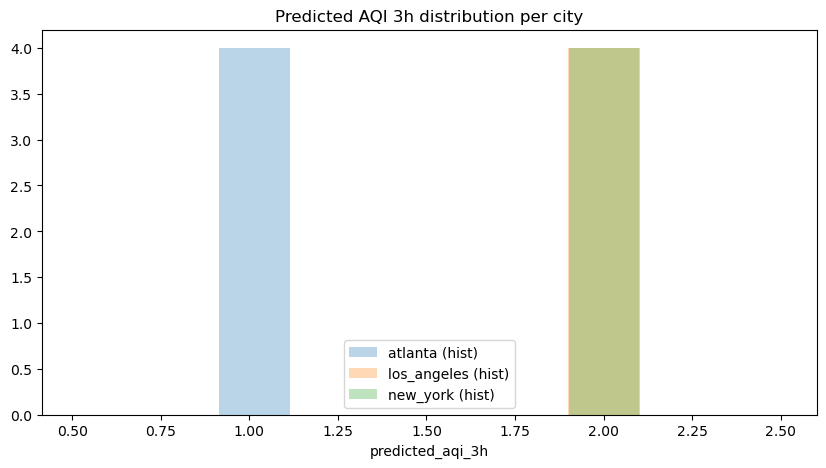

In [6]:
plt.figure(figsize=(10, 5))

for city, sub in df.groupby("city"):
    values = sub["predicted_aqi_3h"].dropna()

    # Must have at least 3 distinct values for KDE to work
    if values.nunique() >= 3:
        values.plot(kind="kde", label=f"{city} (KDE)")
    else:
        plt.hist(
            values,
            bins=5,
            alpha=0.3,
            label=f"{city} (hist)"
        )

plt.title("Predicted AQI 3h distribution per city")
plt.xlabel("predicted_aqi_3h")
plt.legend()
plt.show()

In [ ]:
# import sys

# # project root = one level up from notebooks/
# root = Path("..").resolve()

# # add src/ to the Python path
# sys.path.append(str(root / "src"))

In [8]:
from monitoring_utils import compute_drift_metrics

# Split into baseline (first 20%) and recent (last 20%)
n = len(df)
baseline = df.iloc[: int(n * 0.2)]
recent = df.iloc[int(n * 0.8):]

columns_to_check = ["pm2_5", "pm10", "temp_c", "humidity", "predicted_aqi_3h"]

drift_report = {}

for col in columns_to_check:
    drift_report[col] = compute_drift_metrics(baseline, recent, col)

pd.DataFrame(drift_report).T

,PSI,KS_pvalue,mean_delta,std_delta,note
pm2_5,None,None,None,None,Not enough data for drift analysis
pm10,None,None,None,None,Not enough data for drift analysis
temp_c,None,None,None,None,Not enough data for drift analysis
humidity,None,None,None,None,Not enough data for drift analysis
predicted_aqi_3h,None,None,None,None,Not enough data for drift analysis
